In [1]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import SGD
from keras import backend as K
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import PIL
from PIL import Image
import pandas as pd
import random

Using TensorFlow backend.


In [2]:
data = pd.read_csv('id_genre_pairs.csv')
movie_ids = list(data['movie_id'])
data = np.array(data)


In [3]:
def convert_data_to_size(width,height):
    ####Convert Data to same size 
    for row in data:
        try:
            img = Image.open('Movie Posters/'+str(row[0])+'.jpg')
            img = img.resize((width,height), PIL.Image.ANTIALIAS)
            img.save('Movie Posters Resized '+str(width)+"x"+str(height)+'/'+str(row[0]) + ".jpg", "JPEG")
        except:
            pass


In [4]:
import os
files = [i for i in os.listdir('Movie Posters Resized 32x32') if i[-3:] == 'jpg']
random.shuffle(files)

training_indices = files[:int(len(files)*0.8)]
test_indices = files[int(len(files)*0.8):]

test = []
test_labels = []
for i in test_indices:
    try:
        img = load_img('Movie Posters Resized 32x32/'+i)
        test.append(img_to_array(img))
        idx = int(i[:i.index(".")])
        for row in data:
            if row[0] == idx:
                test_labels.append(row[1:])
                break
    except:
        pass
    

In [9]:
train = []
train_labels = []
for i in training_indices:
    try:
        img = load_img('Movie Posters Resized 32x32/'+i)
        train.append(img_to_array(img))
        idx = int(i[:i.index(".")])
        for row in data:
            if row[0] == idx:
                train_labels.append(row[1:])
                break
    except:
        pass


In [11]:
img_rows, img_cols = 32, 32
num_classes = 17

x_train = np.array(train) 
x_test = np.array(test)

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 3, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)


y_train = np.array(train_labels)
y_test = np.array(test_labels)

# interestingly the keras example code does not center the data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


x_train shape: (11757, 32, 32, 3)
x_test shape: (2940, 32, 32, 3)
11757 train samples
2940 test samples


In [12]:
# create an empty network model
model = Sequential()

# --- input layer ---
model.add(Conv2D(16, kernel_size=(5, 5), activation='sigmoid', input_shape=input_shape))
# --- max pool ---
model.add(MaxPooling2D(pool_size=(2, 2)))

# --- next layer ---
# we could double the number of filters as max pool made the 
# feature maps much smaller 
# just not doing this to improve runtime
model.add(Conv2D(32, kernel_size=(3, 3), activation='sigmoid'))
# --- max pool ---
model.add(MaxPooling2D(pool_size=(2, 2)))

# flatten for fully connected classification layer
model.add(Flatten())
# note that the 10 is the number of classes we have
# the classes are mutually exclusive so softmax is a good choice
# --- fully connected layer ---
model.add(Dense(64, activation='sigmoid'))
# --- classification ---
model.add(Dense(17, activation='softmax'))

# prints out a summary of the model architecture
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 16)        1216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                73792     
_________________________________________________________________
dense_2 (Dense)              (None, 17)                1105      
Total para

In [13]:
# this does all necessary compiling. In tensorflow this is much quicker than in theano
# the setup is our basic categorical crossentropy with stochastic gradient decent
# we also specify that we want to evaluate our model in terms of accuracy
sgd = SGD(lr=0.1, momentum=0.9)
model.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [14]:
# smaller batch size means noisier gradient, but more updates per epoch
batch_size = 512
# number of iterations over the complete training data
epochs = 20

# this is now the actual training
# in addition to the training data we provide validation data
# this data is used to calculate the performance of the model over all the epochs
# this is useful to determine when training should stop
# in our case we just use it to monitor the evolution of the model over the training epochs
# if we use the validation data to determine when to stop the training or which model to save, we 
# should not use the test data, but a separate validation set. 
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

# once training is complete, let's see how well we have done
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 11757 samples, validate on 2940 samples
Epoch 1/20
11757/11757 [==============================] - 19s - loss: 0.2686 - acc: 0.9171 - val_loss: 0.2556 - val_acc: 0.9169
Epoch 2/20
11757/11757 [==============================] - 15s - loss: 0.2529 - acc: 0.9171 - val_loss: 0.2528 - val_acc: 0.9169
Epoch 3/20
11757/11757 [==============================] - 16s - loss: 0.2521 - acc: 0.9171 - val_loss: 0.2528 - val_acc: 0.9169
Epoch 4/20
11757/11757 [==============================] - 16s - loss: 0.2520 - acc: 0.9171 - val_loss: 0.2528 - val_acc: 0.9169
Epoch 5/20
11757/11757 [==============================] - 16s - loss: 0.2521 - acc: 0.9171 - val_loss: 0.2528 - val_acc: 0.9169
Epoch 6/20
11757/11757 [==============================] - 17s - loss: 0.2520 - acc: 0.9171 - val_loss: 0.2528 - val_acc: 0.9169
Epoch 7/20
11757/11757 [==============================] - 15s - loss: 0.2520 - acc: 0.9171 - val_loss: 0.2528 - val_acc: 0.9169
Epoch 8/20
11757/11757 [==============================]

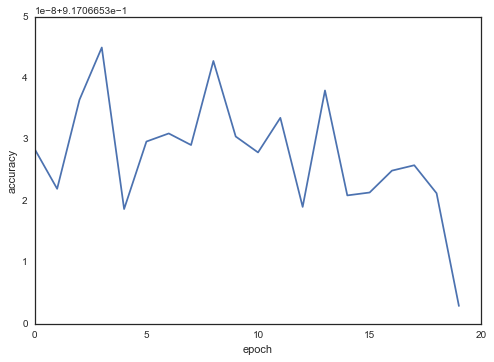

In [15]:
# here is a visualization of the training process
# typically we gain a lot in the beginning and then
# training slows down
plt.plot(history.history['acc'])
plt.xlabel("epoch")
plt.ylabel("accuracy")

Shape of W
(5, 5, 3, 16)


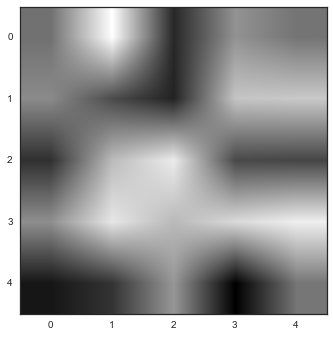

In [16]:
# Look at the weights of the first layer
layer = model.layers[0]
# this actually returns a list 
# first element is W
# second element are all the biases b
weights = layer.get_weights()
# the weights are the number of pixels times the number of filters (hidden units)
print("Shape of W")
print(weights[0].shape)

# look at just the first filter
w = weights[0][:,:,0,0]
w = w.reshape((5,5))
plt.imshow(w, cmap='gray')

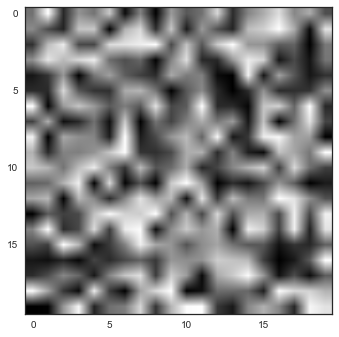

In [17]:
# make a figure for the first 25 filters
filterTiles = np.array([])
index = 0
for i in range(4):
    filterRow = []
    for j in range(4):
        w = weights[0][:,:,0,index]
        w = w.reshape(5,5)
        w = w-np.min(w)
        w = w / np.max(w)
        filterRow.extend(w)
        index+=1
    filterRow = np.array(filterRow)
    if not filterTiles.shape[0] == 0:
        filterTiles = np.hstack([filterTiles, filterRow])
    else:
        filterTiles = filterRow

plt.imshow(filterTiles, cmap='gray')    
plt.show()



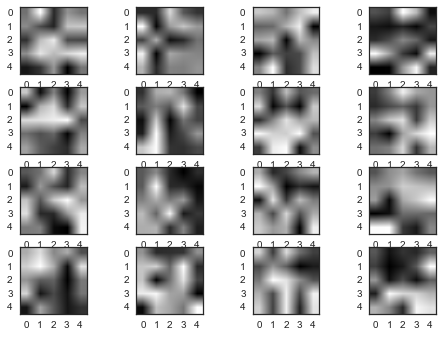

In [18]:
# make a figure for the first 25 filters
index = 0
for i in range(4):
    for j in range(4):
        w = weights[0][:,:,0,index]
        w = w.reshape(5,5)
        index+=1
        plt.subplot(4,4,index)
        plt.imshow(w, cmap='gray')    

plt.show()